# LightGCN: Simplifying Graph Convolution Networks for Recommendation

This notebook implements LightGCN, a simple yet effective Graph Neural Network for collaborative filtering.

**Key Features:**
- User-Item bipartite graph structure
- Simple neighborhood aggregation (no feature transformation)
- Multi-layer graph convolution for high-order connectivity
- Layer combination for final embeddings

**Reference:** He et al., "LightGCN: Simplifying and Powering Graph Convolution Network for Recommendation"

## 1. Setup and Configuration

In [1]:
import os
import platform
import numpy as np
import pandas as pd
import scipy.sparse as sp
import pickle
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Check device
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using Apple Silicon GPU (MPS)')
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using NVIDIA GPU (CUDA)')
else:
    device = torch.device('cpu')
    print('Using CPU')

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

Using Apple Silicon GPU (MPS)


In [2]:
CONFIG = {
    # Paths
    'data_dir': '../data/processed',
    'model_dir': '../models',
    'results_dir': '../results',
    
    # Model hyperparameters
    'embedding_dim': 64,
    'n_layers': 3,  # Number of graph conv layers
    
    # Training
    'learning_rate': 0.001,
    'weight_decay': 1e-5,
    'batch_size': 1024,
    'n_epochs': 50,
    'n_negatives': 1,
    
    # Evaluation
    'top_k': [5, 10, 20],
    'eval_every': 5,
}

Path(CONFIG['model_dir']).mkdir(parents=True, exist_ok=True)
Path(CONFIG['results_dir']).mkdir(parents=True, exist_ok=True)

print("Configuration:")
for k, v in CONFIG.items():
    if not k.endswith('_dir'):
        print(f"  {k}: {v}")

Configuration:
  embedding_dim: 64
  n_layers: 3
  learning_rate: 0.001
  weight_decay: 1e-05
  batch_size: 1024
  n_epochs: 50
  n_negatives: 1
  top_k: [5, 10, 20]
  eval_every: 5


## 2. Load Graph Data

In [3]:
# Load graph structure
with open(os.path.join(CONFIG['data_dir'], 'graph.pkl'), 'rb') as f:
    graph_data = pickle.load(f)

edge_index = graph_data['edge_index']
n_users = graph_data['n_users']
n_items = graph_data['n_items']
n_nodes = n_users + n_items

print(f"Graph loaded:")
print(f"  Users: {n_users:,}")
print(f"  Items: {n_items:,}")
print(f"  Total nodes: {n_nodes:,}")
print(f"  Edges: {edge_index.shape[1]:,}")

Graph loaded:
  Users: 357
  Items: 479
  Total nodes: 836
  Edges: 5,202


In [4]:
# Load interaction matrices for training and evaluation
train_matrix = sp.load_npz(os.path.join(CONFIG['data_dir'], 'train_matrix.npz'))
val_matrix = sp.load_npz(os.path.join(CONFIG['data_dir'], 'val_matrix.npz'))
test_matrix = sp.load_npz(os.path.join(CONFIG['data_dir'], 'test_matrix.npz'))

# Create training pairs
train_coo = train_matrix.tocoo()
train_users = train_coo.row
train_items = train_coo.col

# User positive items for negative sampling
user_positive_items = {}
for u, i in zip(train_users, train_items):
    if u not in user_positive_items:
        user_positive_items[u] = set()
    user_positive_items[u].add(i)

print(f"\nTraining pairs: {len(train_users):,}")


Training pairs: 2,315


## 3. Build Normalized Adjacency Matrix

In [5]:
def build_sparse_graph(n_users, n_items, train_matrix):
    """
    Build normalized adjacency matrix for LightGCN.
    
    The graph is:
    A = | 0    R  |
        | R^T  0  |
    
    Normalized as: D^(-1/2) * A * D^(-1/2)
    """
    # Build adjacency matrix
    R = train_matrix.tocoo()
    
    # Create bipartite adjacency
    row = np.concatenate([R.row, R.col + n_users])
    col = np.concatenate([R.col + n_users, R.row])
    data = np.ones(len(row))
    
    adj = sp.coo_matrix((data, (row, col)), shape=(n_users + n_items, n_users + n_items))
    
    # Compute degree
    degrees = np.array(adj.sum(axis=1)).flatten()
    degrees[degrees == 0] = 1  # Avoid division by zero
    
    # D^(-1/2)
    d_inv_sqrt = np.power(degrees, -0.5)
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    
    # Normalize: D^(-1/2) * A * D^(-1/2)
    D_inv_sqrt = sp.diags(d_inv_sqrt)
    norm_adj = D_inv_sqrt @ adj @ D_inv_sqrt
    
    return norm_adj.tocoo()

# Build normalized graph
norm_adj = build_sparse_graph(n_users, n_items, train_matrix)

# Convert to PyTorch sparse tensor
# NOTE: MPS does not support sparse tensors, so we keep it on CPU
# The model will handle moving embeddings to the right device
indices = torch.LongTensor(np.vstack([norm_adj.row, norm_adj.col]))
values = torch.FloatTensor(norm_adj.data)
shape = torch.Size(norm_adj.shape)

# Keep sparse tensor on CPU (MPS doesn't support sparse ops)
adj_tensor = torch.sparse_coo_tensor(indices, values, shape)

# Determine if we need CPU fallback for sparse operations
use_cpu_for_sparse = (device.type == 'mps')
if use_cpu_for_sparse:
    print("Note: MPS detected - sparse operations will use CPU, dense ops will use MPS")

print(f"Normalized adjacency matrix: {norm_adj.shape}")
print(f"Non-zero entries: {norm_adj.nnz:,}")

Note: MPS detected - sparse operations will use CPU, dense ops will use MPS
Normalized adjacency matrix: (836, 836)
Non-zero entries: 4,630


## 4. BPR Dataset

In [6]:
class BPRDataset(Dataset):
    """Dataset for BPR training."""
    def __init__(self, users, items, n_items, user_positive_items, n_negatives=1):
        self.users = users
        self.items = items
        self.n_items = n_items
        self.user_positive_items = user_positive_items
        self.n_negatives = n_negatives
        
    def __len__(self):
        return len(self.users) * self.n_negatives
    
    def __getitem__(self, idx):
        pair_idx = idx // self.n_negatives
        user = self.users[pair_idx]
        pos_item = self.items[pair_idx]
        
        neg_item = np.random.randint(0, self.n_items)
        while neg_item in self.user_positive_items.get(user, set()):
            neg_item = np.random.randint(0, self.n_items)
        
        return {
            'user': torch.tensor(user, dtype=torch.long),
            'pos_item': torch.tensor(pos_item, dtype=torch.long),
            'neg_item': torch.tensor(neg_item, dtype=torch.long)
        }

train_dataset = BPRDataset(train_users, train_items, n_items, user_positive_items, CONFIG['n_negatives'])
train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=0)

print(f"Training samples: {len(train_dataset):,}")

Training samples: 2,315


## 5. LightGCN Model

In [7]:
class LightGCN(nn.Module):
    """
    LightGCN: Simplified Graph Convolution for Recommendation.
    
    Key idea: Only use neighborhood aggregation, no feature transformation.
    Final embedding = mean of embeddings from all layers (including layer 0).
    """
    def __init__(self, n_users, n_items, embedding_dim, n_layers):
        super().__init__()
        
        self.n_users = n_users
        self.n_items = n_items
        self.n_layers = n_layers
        
        # Only learnable parameters: initial embeddings
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        
        # Initialize
        nn.init.normal_(self.user_embedding.weight, std=0.1)
        nn.init.normal_(self.item_embedding.weight, std=0.1)
        
    def forward(self, adj):
        """
        Perform graph convolution and return final embeddings.
        
        Args:
            adj: Normalized adjacency matrix (sparse tensor on CPU)
            
        Returns:
            user_emb: (n_users, dim)
            item_emb: (n_items, dim)
        """
        # Get the device of embeddings (could be MPS or CUDA)
        embed_device = self.user_embedding.weight.device
        
        # Combine user and item embeddings - move to CPU for sparse matmul
        all_emb = torch.cat([self.user_embedding.weight, self.item_embedding.weight], dim=0)
        all_emb_cpu = all_emb.cpu()  # Move to CPU for sparse ops
        
        # Store embeddings from each layer
        emb_list = [all_emb_cpu]
        
        # Graph convolution layers (on CPU with sparse tensor)
        for layer in range(self.n_layers):
            all_emb_cpu = torch.sparse.mm(adj, all_emb_cpu)
            emb_list.append(all_emb_cpu)
        
        # Average embeddings from all layers
        all_emb_cpu = torch.stack(emb_list, dim=1).mean(dim=1)
        
        # Move back to original device
        all_emb = all_emb_cpu.to(embed_device)
        
        # Split back to users and items
        user_emb, item_emb = torch.split(all_emb, [self.n_users, self.n_items])
        
        return user_emb, item_emb
    
    def get_embedding(self, adj, users, pos_items, neg_items):
        """
        Get embeddings for specific users and items.
        """
        user_emb, item_emb = self.forward(adj)
        
        u_emb = user_emb[users]
        pos_emb = item_emb[pos_items]
        neg_emb = item_emb[neg_items]
        
        # Also return initial embeddings for regularization
        u_emb_0 = self.user_embedding(users)
        pos_emb_0 = self.item_embedding(pos_items)
        neg_emb_0 = self.item_embedding(neg_items)
        
        return u_emb, pos_emb, neg_emb, u_emb_0, pos_emb_0, neg_emb_0

# Initialize model
model = LightGCN(
    n_users=n_users,
    n_items=n_items,
    embedding_dim=CONFIG['embedding_dim'],
    n_layers=CONFIG['n_layers']
)
model = model.to(device)

print("LightGCN Model:")
print(f"  Embedding dim: {CONFIG['embedding_dim']}")
print(f"  GCN layers: {CONFIG['n_layers']}")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")

LightGCN Model:
  Embedding dim: 64
  GCN layers: 3
  Total parameters: 53,504


## 6. BPR Loss with L2 Regularization

In [8]:
def bpr_loss(u_emb, pos_emb, neg_emb, u_emb_0, pos_emb_0, neg_emb_0, reg_weight=1e-5):
    """
    BPR loss with L2 regularization on initial embeddings.
    """
    # BPR loss
    pos_scores = (u_emb * pos_emb).sum(dim=1)
    neg_scores = (u_emb * neg_emb).sum(dim=1)
    bpr = -torch.log(torch.sigmoid(pos_scores - neg_scores) + 1e-8).mean()
    
    # L2 regularization on initial embeddings
    reg = reg_weight * (
        u_emb_0.norm(2).pow(2) + 
        pos_emb_0.norm(2).pow(2) + 
        neg_emb_0.norm(2).pow(2)
    ) / u_emb_0.shape[0]
    
    return bpr + reg

optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])

print("Loss: BPR + L2 Regularization")
print(f"Optimizer: Adam (lr={CONFIG['learning_rate']})")

Loss: BPR + L2 Regularization
Optimizer: Adam (lr=0.001)


## 7. Evaluation

In [9]:
def evaluate_model(model, adj, test_matrix, train_matrix, k_values=[5, 10, 20], batch_size=256):
    """
    Evaluate LightGCN on ranking metrics.
    """
    model.eval()
    
    with torch.no_grad():
        user_emb, item_emb = model(adj)
        user_emb = user_emb.cpu().numpy()
        item_emb = item_emb.cpu().numpy()
    
    # Get test users
    test_coo = test_matrix.tocoo()
    test_users = np.unique(test_coo.row)
    
    # Ground truth
    test_user_items = {}
    for u, i in zip(test_coo.row, test_coo.col):
        if u not in test_user_items:
            test_user_items[u] = []
        test_user_items[u].append(i)
    
    # Training items to exclude
    train_csr = train_matrix.tocsr()
    
    metrics = {f'Precision@{k}': [] for k in k_values}
    metrics.update({f'Recall@{k}': [] for k in k_values})
    metrics.update({f'NDCG@{k}': [] for k in k_values})
    metrics.update({f'HR@{k}': [] for k in k_values})
    
    for i in range(0, len(test_users), batch_size):
        batch_users = test_users[i:i+batch_size]
        
        # Compute scores
        scores = user_emb[batch_users] @ item_emb.T
        
        # Mask training items
        for idx, user in enumerate(batch_users):
            train_items = train_csr[user].indices
            scores[idx, train_items] = -np.inf
        
        # Get top-K
        max_k = max(k_values)
        top_items = np.argsort(-scores, axis=1)[:, :max_k]
        
        # Compute metrics
        for idx, user in enumerate(batch_users):
            if user not in test_user_items:
                continue
            
            ground_truth = set(test_user_items[user])
            
            for k in k_values:
                top_k = top_items[idx, :k]
                hits = len(set(top_k) & ground_truth)
                
                metrics[f'Precision@{k}'].append(hits / k)
                metrics[f'Recall@{k}'].append(hits / len(ground_truth))
                metrics[f'HR@{k}'].append(1.0 if hits > 0 else 0.0)
                
                dcg = sum([1.0 / np.log2(j + 2) for j, item in enumerate(top_k) if item in ground_truth])
                idcg = sum([1.0 / np.log2(j + 2) for j in range(min(k, len(ground_truth)))])
                metrics[f'NDCG@{k}'].append(dcg / idcg if idcg > 0 else 0.0)
    
    return {k: np.mean(v) for k, v in metrics.items()}

## 8. Training

In [10]:
def train_epoch(model, adj, train_loader, optimizer, device, reg_weight=1e-5):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    
    for batch in tqdm(train_loader, desc='Training', leave=False):
        users = batch['user'].to(device)
        pos_items = batch['pos_item'].to(device)
        neg_items = batch['neg_item'].to(device)
        
        # Get embeddings
        u_emb, pos_emb, neg_emb, u_emb_0, pos_emb_0, neg_emb_0 = model.get_embedding(
            adj, users, pos_items, neg_items
        )
        
        # Compute loss
        loss = bpr_loss(u_emb, pos_emb, neg_emb, u_emb_0, pos_emb_0, neg_emb_0, reg_weight)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

In [11]:
# Training loop
print("Starting training...")
print("="*60)

history = {'loss': [], 'val_ndcg': []}
best_ndcg = 0
best_epoch = 0

for epoch in range(1, CONFIG['n_epochs'] + 1):
    loss = train_epoch(model, adj_tensor, train_loader, optimizer, device, CONFIG['weight_decay'])
    history['loss'].append(loss)
    
    if epoch % CONFIG['eval_every'] == 0 or epoch == 1:
        val_metrics = evaluate_model(model, adj_tensor, val_matrix, train_matrix, CONFIG['top_k'])
        ndcg = val_metrics['NDCG@10']
        history['val_ndcg'].append(ndcg)
        
        print(f"Epoch {epoch:3d} | Loss: {loss:.4f} | NDCG@10: {ndcg:.4f} | HR@10: {val_metrics['HR@10']:.4f}")
        
        if ndcg > best_ndcg:
            best_ndcg = ndcg
            best_epoch = epoch
            torch.save(model.state_dict(), os.path.join(CONFIG['model_dir'], 'lightgcn_best.pt'))
    else:
        print(f"Epoch {epoch:3d} | Loss: {loss:.4f}")

print("="*60)
print(f"Training complete! Best NDCG@10: {best_ndcg:.4f} at epoch {best_epoch}")

Starting training...


Epoch   1 | Loss: 0.6798 | NDCG@10: 0.0017 | HR@10: 0.0056


Epoch   2 | Loss: 0.6779


Epoch   3 | Loss: 0.6768


Epoch   4 | Loss: 0.6756


Epoch   5 | Loss: 0.6753 | NDCG@10: 0.0026 | HR@10: 0.0084


Epoch   6 | Loss: 0.6740


Epoch   7 | Loss: 0.6730


Epoch   8 | Loss: 0.6721


Epoch   9 | Loss: 0.6714


Epoch  10 | Loss: 0.6701 | NDCG@10: 0.0046 | HR@10: 0.0140


Epoch  11 | Loss: 0.6676


Epoch  12 | Loss: 0.6660


Epoch  13 | Loss: 0.6660


Epoch  14 | Loss: 0.6641


Epoch  15 | Loss: 0.6624 | NDCG@10: 0.0068 | HR@10: 0.0168


Epoch  16 | Loss: 0.6602


Epoch  17 | Loss: 0.6576


Epoch  18 | Loss: 0.6561


Epoch  19 | Loss: 0.6541


Epoch  20 | Loss: 0.6535 | NDCG@10: 0.0047 | HR@10: 0.0112


Epoch  21 | Loss: 0.6501


Epoch  22 | Loss: 0.6466


Epoch  23 | Loss: 0.6447


Epoch  24 | Loss: 0.6427


Epoch  25 | Loss: 0.6394 | NDCG@10: 0.0060 | HR@10: 0.0168


Epoch  26 | Loss: 0.6368


Epoch  27 | Loss: 0.6315


Epoch  28 | Loss: 0.6281


Epoch  29 | Loss: 0.6248


Epoch  30 | Loss: 0.6198 | NDCG@10: 0.0069 | HR@10: 0.0168


Epoch  31 | Loss: 0.6177


Epoch  32 | Loss: 0.6153


Epoch  33 | Loss: 0.6104


Epoch  34 | Loss: 0.6056


Epoch  35 | Loss: 0.5997 | NDCG@10: 0.0070 | HR@10: 0.0168


Epoch  36 | Loss: 0.5963


Epoch  37 | Loss: 0.5868


Epoch  38 | Loss: 0.5863


Epoch  39 | Loss: 0.5808


Epoch  40 | Loss: 0.5724 | NDCG@10: 0.0067 | HR@10: 0.0168


Epoch  41 | Loss: 0.5698


Epoch  42 | Loss: 0.5637


Epoch  43 | Loss: 0.5587


Epoch  44 | Loss: 0.5545


Epoch  45 | Loss: 0.5463 | NDCG@10: 0.0071 | HR@10: 0.0196


Epoch  46 | Loss: 0.5401


Epoch  47 | Loss: 0.5340


Epoch  48 | Loss: 0.5286


Epoch  49 | Loss: 0.5197


Epoch  50 | Loss: 0.5153 | NDCG@10: 0.0064 | HR@10: 0.0168
Training complete! Best NDCG@10: 0.0071 at epoch 45


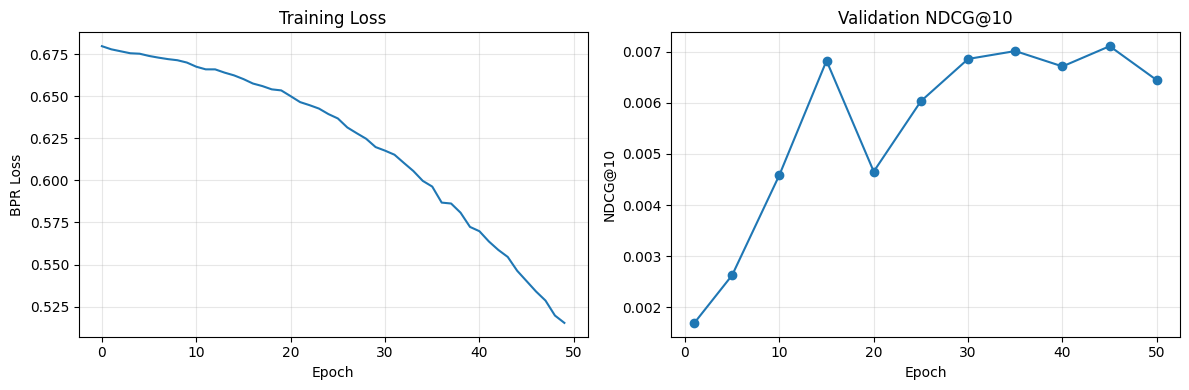

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history['loss'])
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('BPR Loss')
axes[0].set_title('Training Loss')
axes[0].grid(True, alpha=0.3)

eval_epochs = [1] + list(range(CONFIG['eval_every'], CONFIG['n_epochs']+1, CONFIG['eval_every']))
eval_epochs = eval_epochs[:len(history['val_ndcg'])]
axes[1].plot(eval_epochs, history['val_ndcg'], marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('NDCG@10')
axes[1].set_title('Validation NDCG@10')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['results_dir'], 'lightgcn_training.png'), dpi=150)
plt.show()

## 9. Final Evaluation on Test Set

In [13]:
# Load best model
model.load_state_dict(torch.load(os.path.join(CONFIG['model_dir'], 'lightgcn_best.pt')))

# Combine train and val for final test
train_val_matrix = train_matrix + val_matrix
train_val_matrix.data = np.clip(train_val_matrix.data, 0, 1)

test_metrics = evaluate_model(model, adj_tensor, test_matrix, train_val_matrix, CONFIG['top_k'])

print("="*60)
print("FINAL TEST RESULTS - LightGCN")
print("="*60)
for metric, value in sorted(test_metrics.items()):
    print(f"  {metric}: {value:.4f}")

FINAL TEST RESULTS - LightGCN
  HR@10: 0.0084
  HR@20: 0.0168
  HR@5: 0.0028
  NDCG@10: 0.0029
  NDCG@20: 0.0049
  NDCG@5: 0.0011
  Precision@10: 0.0008
  Precision@20: 0.0008
  Precision@5: 0.0006
  Recall@10: 0.0084
  Recall@20: 0.0168
  Recall@5: 0.0028


## 10. Complete Model Comparison

In [14]:
# Load all results
all_results = {'LightGCN': test_metrics}

for model_name, filename in [('MF', 'mf_results.pkl'), ('LSTM', 'lstm_results.pkl'), ('BERT4Rec', 'bert4rec_results.pkl')]:
    try:
        with open(os.path.join(CONFIG['results_dir'], filename), 'rb') as f:
            all_results[model_name] = pickle.load(f)['test_metrics']
    except:
        pass

print("="*80)
print("COMPLETE MODEL COMPARISON")
print("="*80)

models = list(all_results.keys())
header = f"{'Metric':<15}" + "".join([f"{m:>12}" for m in models])
print(header)
print("-"*len(header))

for metric in sorted(test_metrics.keys()):
    row = f"{metric:<15}"
    for model_name in models:
        val = all_results[model_name].get(metric, 0)
        row += f"{val:>12.4f}"
    print(row)

# Find best model for NDCG@10
best_model = max(all_results.keys(), key=lambda m: all_results[m].get('NDCG@10', 0))
print(f"\nBest model (NDCG@10): {best_model}")

COMPLETE MODEL COMPARISON
Metric             LightGCN          MF        LSTM    BERT4Rec
---------------------------------------------------------------
HR@10                0.0084      0.0084      0.0308      0.0168
HR@20                0.0168      0.0224      0.0504      0.0280
HR@5                 0.0028      0.0028      0.0112      0.0112
NDCG@10              0.0029      0.0030      0.0137      0.0086
NDCG@20              0.0049      0.0067      0.0184      0.0115
NDCG@5               0.0011      0.0014      0.0075      0.0070
Precision@10         0.0008      0.0008      0.0031      0.0017
Precision@20         0.0008      0.0011      0.0025      0.0014
Precision@5          0.0006      0.0006      0.0022      0.0022
Recall@10            0.0084      0.0084      0.0308      0.0168
Recall@20            0.0168      0.0224      0.0504      0.0280
Recall@5             0.0028      0.0028      0.0112      0.0112

Best model (NDCG@10): LSTM


In [15]:
# Save LightGCN results
results = {
    'model': 'LightGCN',
    'config': CONFIG,
    'best_epoch': best_epoch,
    'best_val_ndcg': best_ndcg,
    'test_metrics': test_metrics,
    'history': history
}

with open(os.path.join(CONFIG['results_dir'], 'lightgcn_results.pkl'), 'wb') as f:
    pickle.dump(results, f)

with open(os.path.join(CONFIG['results_dir'], 'lightgcn_results.txt'), 'w') as f:
    f.write("LightGCN Results\n")
    f.write("="*40 + "\n\n")
    f.write("Configuration:\n")
    for k, v in CONFIG.items():
        f.write(f"  {k}: {v}\n")
    f.write(f"\nBest Epoch: {best_epoch}\n")
    f.write(f"Best Validation NDCG@10: {best_ndcg:.4f}\n")
    f.write("\nTest Metrics:\n")
    for metric, value in sorted(test_metrics.items()):
        f.write(f"  {metric}: {value:.4f}\n")

print("Results saved!")

Results saved!


## Summary

LightGCN (Graph Neural Network) implemented and trained!

**Key Features:**
- Simple neighborhood aggregation on user-item graph
- No feature transformation (only embeddings)
- Multi-layer aggregation for high-order connectivity
- Layer combination (mean of all layer embeddings)

**All 4 Models Implemented:**
1. Matrix Factorization (baseline)
2. LSTM Sequential Recommender
3. BERT4Rec (Transformer)
4. LightGCN (Graph Neural Network)